# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import talib as ta
import yfinance as yf

# Get Stock Data

In [2]:
ticker_in = 'RELIANCE.NS'
ticker_us = 'AAPL'
a_in = yf.Ticker(ticker_in)
a_us = yf.Ticker(ticker_us)
df_in = a_in.history(start='2013-01-01', end='2018-12-31')
df_us = a_in.history(start='2013-01-01', end='2018-12-31')

stop_l = 0.02

# Strategy definition

In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

def cagr(v_0, v_n, t):
    return round((v_n/v_0)**(1/t) - 1, 4)

class TsgStrategy(Strategy):
    n3 = 14
    n4 = 65
    #n5 = 25
    def init(self):
        close = self.data.Close
        volume = self.data.Volume.astype('float64')
        
        self.upperBB, self.middleBB, self.lowerBB = self.I(ta.BBANDS, close, self.n3)
        self.macd, self.signal, self.hist = self.I(ta.MACD,
            close, 12, 26, self.n4)
        #self.rsi = self.I(ta.RSI, close)
        self.obv = self.I(ta.OBV, close, volume)

    def next(self):
        price = self.data.Close[-1]
        if (price > self.middleBB[-1] and
            #self.rsi[-1] > self.n4 and
            crossover(self.macd, self.signal) and
            self.obv[-1] > self.obv[-2]):
            stop_loss = self.lowerBB[-1]
            self.position.close()
            self.buy(sl=stop_loss)
        elif (price < self.middleBB[-1] and
            #self.rsi[-1] < self.n5 and
            crossover(self.signal, self.macd) and
            self.obv[-1] < self.obv[-2]):
            stop_loss = self.upperBB[-1]
            self.position.close()
            self.sell(sl=stop_loss)

Loading BokehJS ...

# Backtesting TSG Strategy: Indian Stock

  0%|          | 0/9 [00:00<?, ?it/s]

CAGR					 2.91 %
Start                     2013-01-01 00:00:00
End                       2018-12-28 00:00:00
Duration                   2187 days 00:00:00
Exposure Time [%]                    87.88084
Equity Final [$]                 11875.994398
Equity Peak [$]                  16058.994658
Return [%]                          18.759944
Buy & Hold Return [%]              183.033533
Return (Ann.) [%]                    2.976921
Volatility (Ann.) [%]                23.63336
Sharpe Ratio                         0.125963
Sortino Ratio                        0.197603
Calmar Ratio                         0.078555
Max. Drawdown [%]                  -37.896126
Avg. Drawdown [%]                   -7.064045
Max. Drawdown Duration     1286 days 00:00:00
Avg. Drawdown Duration      106 days 00:00:00
# Trades                                   51
Win Rate [%]                        37.254902
Best Trade [%]                      28.359396
Worst Trade [%]                     -8.180084
Avg. Trade [%]   

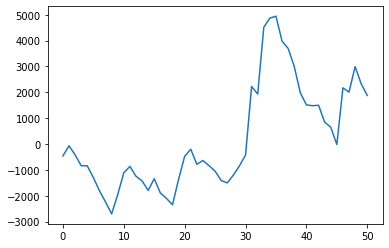

In [4]:
init_cash = 10000
bt = Backtest(df_in, TsgStrategy,
              cash=init_cash, commission=0.002,
              exclusive_orders=True)

stats = bt.optimize(n3=range(5, 15, 1),
                    n4=range(45, 75, 5),
                    #n5=range(25, 35, 5),
                    maximize='Equity Final [$]')
print('CAGR\t\t\t\t\t', 100*cagr(init_cash, stats['Equity Final [$]'], 6), '%')
print(stats)
print(stats._strategy)
plt.plot(np.cumsum(stats['_trades']['PnL']))

# Backtesting Strategy - US Stock

  0%|          | 0/9 [00:00<?, ?it/s]

CAGR					 2.91 %
Start                     2013-01-01 00:00:00
End                       2018-12-28 00:00:00
Duration                   2187 days 00:00:00
Exposure Time [%]                    87.88084
Equity Final [$]                 11875.994398
Equity Peak [$]                  16058.994658
Return [%]                          18.759944
Buy & Hold Return [%]              183.033533
Return (Ann.) [%]                    2.976921
Volatility (Ann.) [%]                23.63336
Sharpe Ratio                         0.125963
Sortino Ratio                        0.197603
Calmar Ratio                         0.078555
Max. Drawdown [%]                  -37.896126
Avg. Drawdown [%]                   -7.064045
Max. Drawdown Duration     1286 days 00:00:00
Avg. Drawdown Duration      106 days 00:00:00
# Trades                                   51
Win Rate [%]                        37.254902
Best Trade [%]                      28.359396
Worst Trade [%]                     -8.180084
Avg. Trade [%]   

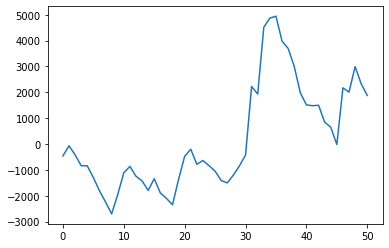

In [5]:
init_cash = 10000
bt = Backtest(df_us, TsgStrategy,
              cash=init_cash, commission=0.002,
              exclusive_orders=True)

stats = bt.optimize(n3=range(5, 15, 1),
                    n4=range(45, 75, 5),
                    #n5=range(25, 35, 5),
                    maximize='Equity Final [$]')

print('CAGR\t\t\t\t\t', 100*cagr(init_cash, stats['Equity Final [$]'], 6), '%')
print(stats)
print(stats._strategy)
plt.plot(np.cumsum(stats['_trades']['PnL']))